In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.amp import GradScaler
from collections import  Counter
import torch.nn.functional as F
import torch.optim as optim
import gc
from torch.optim import lr_scheduler
import cv2
import copy
import random
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")

In [2]:
root_path = Path("/kaggle/input/lyft-udacity-challenge")
dirs = ["dataA", "dataB", "dataC", "dataD", "dataE"]

images = []
masks = []

for d in dirs:
    img_path = root_path / d / d / "CameraRGB"
    msk_path = root_path / d / d / "CameraSeg"
    
    if img_path.exists():
        images.extend(sorted(img_path.glob("*.png")))
        masks.extend(sorted(msk_path.glob("*.png")))

print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")

Total images: 5000
Total masks: 5000


In [3]:
df = pd.DataFrame({"image": images, "mask": masks})

In [4]:
df.head()

,image,mask
0,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
1,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
2,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
3,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
4,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...


In [5]:
print("Duplicate image paths:", df["image"].duplicated().sum())
print("Duplicate mask paths:", df["mask"].duplicated().sum())

Duplicate image paths: 0
Duplicate mask paths: 0


In [6]:
image_shapes = []
for img_path in df["image"].sample(200, random_state=42):
    img = cv2.imread(img_path)
    image_shapes.append(img.shape)

shape_counts = Counter(image_shapes)
shape_counts

Counter({(600, 800, 3): 200})

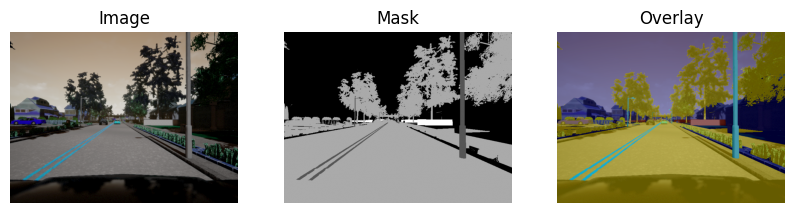

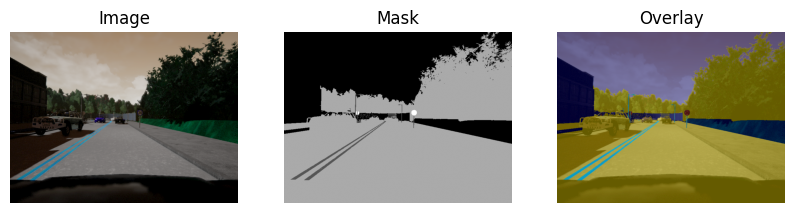

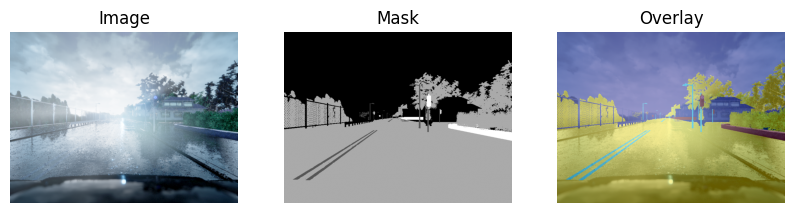

In [7]:
def visualize_sample(img_path, mask_path):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.show()


for idx in random.sample(range(len(df)), 3):
    visualize_sample(df.iloc[idx]["image"], df.iloc[idx]["mask"])

In [8]:
mask_values = set()

for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_values.update(np.unique(mask))

sorted(mask_values)

[np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3)]

In [9]:
# Load as RGB to see actual class encoding
mask_path = df["mask"].iloc[0]
mask_rgb = cv2.imread(mask_path, cv2.IMREAD_COLOR)
mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)

# Get unique colors
unique_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
print(f"Number of unique colors: {len(unique_colors)}")
print("Unique RGB values:")
for color in unique_colors[:10]:
    print(f"  RGB: {color}")

Number of unique colors: 12
Unique RGB values:
  RGB: [0 0 0]
  RGB: [1 0 0]
  RGB: [2 0 0]
  RGB: [3 0 0]
  RGB: [5 0 0]
  RGB: [6 0 0]
  RGB: [7 0 0]
  RGB: [8 0 0]
  RGB: [9 0 0]
  RGB: [10  0  0]


In [10]:
class_ids = set()
for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    red_channel = mask[:, :, 2] 
    class_ids.update(np.unique(red_channel))

print(f"Total classes: {len(class_ids)}")
print(f"Class IDs: {sorted(class_ids)}")

Total classes: 13
Class IDs: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12)]


In [11]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing "image" and "mask" paths.
            transform (albumentations.Compose): Transformation pipeline.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 1. Fetch paths
        img_path = str(self.df.iloc[idx]["image"])
        mask_path = str(self.df.iloc[idx]["mask"])
        
        # 2. Read Image (BGR to RGB)
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
   
        mask_bgr = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        if mask_bgr is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        mask = mask_bgr[:, :, 2]
        
        # 4. Apply Transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long() 
            
        return image, mask

In [13]:
train_val_idx, test_idx = train_test_split(
    range(len(df)), 
    test_size=0.1, 
    random_state=42
)


train_idx, val_idx = train_test_split(
    train_val_idx, 
    test_size=0.2,  
    random_state=42
)


train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"\nDataset split:")
print(f"Train: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")


train_dataset = SegmentationDataset(train_df, transform=train_transform)
val_dataset = SegmentationDataset(val_df, transform=val_test_transform)
test_dataset = SegmentationDataset(test_df, transform=val_test_transform)


Dataset split:
Train: 3600 samples (72.0%)
Validation: 900 samples (18.0%)
Test: 500 samples (10.0%)


In [14]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttentionModule, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        cat_out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.conv(cat_out)
        M = torch.sigmoid(out)
        return x * M

In [15]:
class SEBlock(nn.Module):
  def __init__(self, in_channels, reduction=16):
    super(SEBlock, self).__init__()
    reduced = max(1, in_channels // reduction)
    self.avg_global_pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Conv2d(in_channels, reduced, 1)
    self.relu = nn.ReLU(inplace=True)
    self.fc_out = nn.Conv2d(reduced, in_channels, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_pooling = self.avg_global_pooling(x)
    fc1 = self.fc(avg_pooling)
    relu = self.relu(fc1)
    fc2 = self.fc_out(relu)
    sigmoid = self.sigmoid(fc2)
    return x * sigmoid

In [16]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = SEBlock(in_channels, reduction)
        self.spatial_attention = SpatialAttentionModule(kernel_size)

    def forward(self, x):
      x = self.channel_attention.forward(x)
      x = self.spatial_attention.forward(x)
      return x

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout_p)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x




class ResNet50UNet(nn.Module):
    def __init__(self, n_classes=13, use_cbam=True, dropout_p=0.2, pretrained=True):
        super(ResNet50UNet, self).__init__()
        self.use_cbam = use_cbam
        
        resnet = models.resnet50(pretrained=pretrained)
        
        # ============ ENCODER (ResNet50) ============
        # Stage 1: Initial conv + bn + relu
        self.encoder1 = nn.Sequential(
            resnet.conv1,      # 7x7 conv, 64 channels
            resnet.bn1,
            resnet.relu
        )
        self.cbam_enc1 = CBAM(64, reduction=16) if use_cbam else None
        self.pool1 = resnet.maxpool
        
        # Stage 2-5: ResNet blocks
        self.encoder2 = resnet.layer1  # 256 channels
        self.cbam_enc2 = CBAM(256, reduction=16) if use_cbam else None
        
        self.encoder3 = resnet.layer2  # 512 channels
        self.cbam_enc3 = CBAM(512, reduction=16) if use_cbam else None
        
        self.encoder4 = resnet.layer3  # 1024 channels
        self.cbam_enc4 = CBAM(1024, reduction=16) if use_cbam else None
        
        self.encoder5 = resnet.layer4  # 2048 channels
        self.cbam_enc5 = CBAM(2048, reduction=16) if use_cbam else None
        
        # ============ BOTTLENECK ============
        self.bottleneck = nn.Sequential(
            ConvBlock(2048, 2048, dropout_p=dropout_p * 1.5),
            ConvBlock(2048, 2048, dropout_p=dropout_p * 1.5)
        )
        self.cbam_bottleneck = CBAM(2048, reduction=16) if use_cbam else None
        
        # ============ DECODER ============
        # Decoder 1: 2048 -> 1024
        self.up1 = nn.ConvTranspose2d(2048, 1024, 2, stride=2)
        self.dec1_1 = ConvBlock(2048, 1024, dropout_p=dropout_p)  # 2048 = 1024 (up) + 1024 (skip)
        self.dec1_2 = ConvBlock(1024, 1024, dropout_p=dropout_p)
        self.cbam_dec1 = CBAM(1024, reduction=16) if use_cbam else None
        
        # Decoder 2: 1024 -> 512
        self.up2 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec2_1 = ConvBlock(1024, 512, dropout_p=dropout_p)  # 1024 = 512 (up) + 512 (skip)
        self.dec2_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_dec2 = CBAM(512, reduction=16) if use_cbam else None
        
        # Decoder 3: 512 -> 256
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3_1 = ConvBlock(512, 256, dropout_p=dropout_p)  # 512 = 256 (up) + 256 (skip)
        self.dec3_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_dec3 = CBAM(256, reduction=16) if use_cbam else None
        
        # Decoder 4: 256 -> 64
        self.up4 = nn.ConvTranspose2d(256, 64, 2, stride=2)
        self.dec4_1 = ConvBlock(128, 64, dropout_p=dropout_p)  # 128 = 64 (up) + 64 (skip)
        self.dec4_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_dec4 = CBAM(64, reduction=16) if use_cbam else None
        
        # Decoder 5: Final upsampling to original size
        self.up5 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec5 = ConvBlock(64, 64, dropout_p=dropout_p)
        
        # Final output layer
        self.out = nn.Conv2d(64, n_classes, 1)
        
    def center_crop(self, encoder_features, decoder_features):
        """Crop encoder features to match decoder spatial dimensions"""
        _, _, h_enc, w_enc = encoder_features.size()
        _, _, h_dec, w_dec = decoder_features.size()
        
        dh = h_enc - h_dec
        dw = w_enc - w_dec
        
        if dh == 0 and dw == 0:
            return encoder_features
        
        h_start = dh // 2
        w_start = dw // 2
        
        return encoder_features[:, :, h_start:h_start+h_dec, w_start:w_start+w_dec]
    
    def forward(self, x):
        # ============ ENCODER ============
        # Stage 1
        e1 = self.encoder1(x)  # 64 channels
        if self.use_cbam:
            e1 = self.cbam_enc1(e1)
        p1 = self.pool1(e1)
        
        # Stage 2
        e2 = self.encoder2(p1)  # 256 channels
        if self.use_cbam:
            e2 = self.cbam_enc2(e2)
        
        # Stage 3
        e3 = self.encoder3(e2)  # 512 channels
        if self.use_cbam:
            e3 = self.cbam_enc3(e3)
        
        # Stage 4
        e4 = self.encoder4(e3)  # 1024 channels
        if self.use_cbam:
            e4 = self.cbam_enc4(e4)
        
        # Stage 5
        e5 = self.encoder5(e4)  # 2048 channels
        if self.use_cbam:
            e5 = self.cbam_enc5(e5)
        
        # ============ BOTTLENECK ============
        b = self.bottleneck(e5)
        if self.use_cbam:
            b = self.cbam_bottleneck(b)
        
        # ============ DECODER ============
        # Decoder 1: 2048 -> 1024
        d1 = self.up1(b)
        d1 = torch.cat([d1, self.center_crop(e4, d1)], dim=1)
        d1 = self.dec1_1(d1)
        d1 = self.dec1_2(d1)
        if self.use_cbam:
            d1 = self.cbam_dec1(d1)
        
        # Decoder 2: 1024 -> 512
        d2 = self.up2(d1)
        d2 = torch.cat([d2, self.center_crop(e3, d2)], dim=1)
        d2 = self.dec2_1(d2)
        d2 = self.dec2_2(d2)
        if self.use_cbam:
            d2 = self.cbam_dec2(d2)
        
        # Decoder 3: 512 -> 256
        d3 = self.up3(d2)
        d3 = torch.cat([d3, self.center_crop(e2, d3)], dim=1)
        d3 = self.dec3_1(d3)
        d3 = self.dec3_2(d3)
        if self.use_cbam:
            d3 = self.cbam_dec3(d3)
        
        # Decoder 4: 256 -> 64
        d4 = self.up4(d3)
        d4 = torch.cat([d4, self.center_crop(e1, d4)], dim=1)
        d4 = self.dec4_1(d4)
        d4 = self.dec4_2(d4)
        if self.use_cbam:
            d4 = self.cbam_dec4(d4)
        
        # Decoder 5: Final upsampling
        d5 = self.up5(d4)
        d5 = self.dec5(d5)
        
        # Output
        out = self.out(d5)
        return out

In [18]:
def multiclass_dice_loss(pred, target, num_classes, smooth=1e-6):
    """Multi-class Dice loss"""
    pred = F.softmax(pred, dim=1)  
    
    dice_loss = 0
    for class_idx in range(num_classes):
        pred_class = pred[:, class_idx]
        target_class = (target == class_idx).float()
        
        pred_flat = pred_class.reshape(-1)
        target_flat = target_class.reshape(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss += (1 - dice)
    
    return dice_loss / num_classes

@torch.no_grad()
def multiclass_dice_score(pred, target, num_classes, smooth=1e-6):
    """Multi-class Dice score"""
    pred = torch.argmax(pred, dim=1)  
    
    dice_scores = []
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        
        if union == 0:
            continue  
            
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice)
    
    return torch.tensor(dice_scores).mean()

@torch.no_grad()
def calculate_miou(pred, target, num_classes):
    """Mean Intersection over Union"""
    pred = torch.argmax(pred, dim=1)
    
    ious = []
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx)
        target_class = (target == class_idx)
        
        intersection = (pred_class & target_class).sum().float()
        union = (pred_class | target_class).sum().float()
        
        if union == 0:
            continue
            
        iou = intersection / union
        ious.append(iou)
    
    return torch.tensor(ious).mean() if ious else torch.tensor(0.0)

In [19]:
class Trainer:
    def __init__(self, model, num_classes=13, patience=7, class_weights=None, 
                 encoder_lr=1e-5, decoder_lr=1e-4):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.num_classes = num_classes

        self.batch_size = 16
        self.accumulation_steps = 4
        
        # Early Stopping
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = copy.deepcopy(model.state_dict())

        self.scaler = GradScaler()

        # Multi-class loss
        if class_weights is not None:
            class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        
        # Separate encoder and decoder parameters
        encoder_params = []
        decoder_params = []
        
        for name, param in model.named_parameters():
            if 'encoder' in name:
                encoder_params.append(param)
            else:
                decoder_params.append(param)
        
        self.optimizer = optim.Adam([
            {'params': encoder_params, 'lr': encoder_lr, 'weight_decay': 1e-5},
            {'params': decoder_params, 'lr': decoder_lr, 'weight_decay': 1e-5}
        ])

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )

    def combined_loss(self, outputs, targets):
        """Combined CrossEntropy + Dice Loss for multi-class segmentation"""
        ce = self.ce_loss(outputs, targets)
        dice = multiclass_dice_loss(outputs, targets, num_classes=self.num_classes)
        return 0.5 * ce + 0.5 * dice

    def get_loader(self, dataset, shuffle=True):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True
        )

    def clean_memory(self):
        gc.collect()
        torch.cuda.empty_cache()

    def train_epoch(self, data_loader, epoch_idx):
        self.model.train()
        loss_total = 0.0

        self.optimizer.zero_grad(set_to_none=True)
        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Train]", leave=False)

        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)
                loss = loss / self.accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % self.accumulation_steps == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            loss_val = loss.item() * self.accumulation_steps
            loss_total += loss_val
            loop.set_postfix(loss=loss_val)

        if len(data_loader) % self.accumulation_steps != 0:
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)
        
        self.clean_memory()

        avg_loss = loss_total / len(data_loader)
        print(f"Epoch {epoch_idx + 1} | Train Loss: {avg_loss:.4f}")
        return avg_loss

    @torch.no_grad()
    def validate_epoch(self, data_loader, epoch_idx):
        self.model.eval()

        val_loss = 0.0
        val_dice = 0.0
        val_miou = 0.0

        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Val]", leave=False)

        for data, target in loop:
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)

            val_loss += loss.item()
            val_dice += multiclass_dice_score(output, target, self.num_classes).item()
            val_miou += calculate_miou(output, target, self.num_classes).item()

        val_loss /= len(data_loader)
        val_dice /= len(data_loader)
        val_miou /= len(data_loader)

        self.clean_memory()

        current_lr = self.optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch_idx + 1} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Dice: {val_dice:.4f} | "
            f"Val mIoU: {val_miou:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        self.scheduler.step(val_loss)

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(self.model.state_dict())
            torch.save(self.model.state_dict(), 'best_model.pth')
            print("  -> New best model saved!")
        else:
            self.counter += 1
            print(f"  -> EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return val_loss, val_dice, val_miou

    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            self.train_epoch(train_loader, epoch)
            self.validate_epoch(val_loader, epoch)
            
            if self.early_stop:
                print("Early stopping triggered.")
                self.model.load_state_dict(self.best_model_wts)
                break

        self.clean_memory()   

In [20]:
class_weights = np.array([
    0,   # 0: Unlabeled 
    1.0,   # 1: Building
    1.2,   # 2: Fence
    1.0,   # 3: Other
    5.0,   # 4: Pedestria
    2.0,   # 5: Pole
    3.0,   # 6: RoadLine
    3.0,   # 7: Road 
    1.0,   # 8: Sidewalk
    0.8,   # 9: Vegetatio
    3.0,   # 10: Vehicles 
    1.5,   # 11: Wall
    5.0    # 12: TrafficSign
], dtype=np.float32)

print("Using predefined class weights for CARLA dataset")
CLASS_NAMES = ["Unlabeled", "Building", "Fence", "Other", "Pedestrian", 
               "Pole", "RoadLine", "Road", "Sidewalk", "Vegetation", 
               "Vehicles", "Wall", "TrafficSign"]

for i, (name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"{i:2d}. {name:15s}: Weight: {weight:.2f}")

Using predefined class weights for CARLA dataset
 0. Unlabeled      : Weight: 0.00
 1. Building       : Weight: 1.00
 2. Fence          : Weight: 1.20
 3. Other          : Weight: 1.00
 4. Pedestrian     : Weight: 5.00
 5. Pole           : Weight: 2.00
 6. RoadLine       : Weight: 3.00
 7. Road           : Weight: 3.00
 8. Sidewalk       : Weight: 1.00
 9. Vegetation     : Weight: 0.80
10. Vehicles       : Weight: 3.00
11. Wall           : Weight: 1.50
12. TrafficSign    : Weight: 5.00


In [21]:
model = ResNet50UNet(
    n_classes=13, 
    use_cbam=True,      
    dropout_p=0.2, 
    pretrained=True     
)

trainer = Trainer(
    model, 
    num_classes=13, 
    patience=10,
    class_weights=class_weights,  
    encoder_lr=1e-5,            
    decoder_lr=1e-4                
)


train_loader = trainer.get_loader(train_dataset, shuffle=True)
val_loader = trainer.get_loader(val_dataset, shuffle=False)


trainer.fit(train_loader, val_loader, epochs=100)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Epoch 1 | Train Loss: 1.1854


Epoch 1 | Val Loss: 0.8110 | Val Dice: 0.1833 | Val mIoU: 0.1623 | LR: 0.000010
  -> New best model saved!


Epoch 2 | Train Loss: 0.8157


Epoch 2 | Val Loss: 0.6993 | Val Dice: 0.3243 | Val mIoU: 0.2730 | LR: 0.000010
  -> New best model saved!


Epoch 3 | Train Loss: 0.7266


Epoch 3 | Val Loss: 0.6172 | Val Dice: 0.3269 | Val mIoU: 0.2901 | LR: 0.000010
  -> New best model saved!


Epoch 4 | Train Loss: 0.6631


Epoch 4 | Val Loss: 0.5586 | Val Dice: 0.3461 | Val mIoU: 0.3051 | LR: 0.000010
  -> New best model saved!


Epoch 5 | Train Loss: 0.6092


Epoch 5 | Val Loss: 0.5008 | Val Dice: 0.4201 | Val mIoU: 0.3844 | LR: 0.000010
  -> New best model saved!


Epoch 6 | Train Loss: 0.5642


Epoch 6 | Val Loss: 0.4678 | Val Dice: 0.4237 | Val mIoU: 0.3905 | LR: 0.000010
  -> New best model saved!


Epoch 7 | Train Loss: 0.5329


Epoch 7 | Val Loss: 0.4513 | Val Dice: 0.4253 | Val mIoU: 0.3928 | LR: 0.000010
  -> New best model saved!


Epoch 8 | Train Loss: 0.5100


Epoch 8 | Val Loss: 0.4371 | Val Dice: 0.4285 | Val mIoU: 0.3982 | LR: 0.000010
  -> New best model saved!


Epoch 9 | Train Loss: 0.4905


Epoch 9 | Val Loss: 0.4234 | Val Dice: 0.4796 | Val mIoU: 0.4376 | LR: 0.000010
  -> New best model saved!


Epoch 10 | Train Loss: 0.4742


Epoch 10 | Val Loss: 0.4108 | Val Dice: 0.4952 | Val mIoU: 0.4576 | LR: 0.000010
  -> New best model saved!


Epoch 11 | Train Loss: 0.4626


Epoch 11 | Val Loss: 0.4033 | Val Dice: 0.4950 | Val mIoU: 0.4570 | LR: 0.000010
  -> New best model saved!


Epoch 12 | Train Loss: 0.4507


Epoch 12 | Val Loss: 0.3950 | Val Dice: 0.4976 | Val mIoU: 0.4610 | LR: 0.000010
  -> New best model saved!


Epoch 13 | Train Loss: 0.4431


Epoch 13 | Val Loss: 0.3894 | Val Dice: 0.4983 | Val mIoU: 0.4604 | LR: 0.000010
  -> New best model saved!


Epoch 14 | Train Loss: 0.4328


Epoch 14 | Val Loss: 0.3827 | Val Dice: 0.5076 | Val mIoU: 0.4675 | LR: 0.000010
  -> New best model saved!


Epoch 15 | Train Loss: 0.4260


Epoch 15 | Val Loss: 0.3773 | Val Dice: 0.5343 | Val mIoU: 0.4861 | LR: 0.000010
  -> New best model saved!


Epoch 16 | Train Loss: 0.4188


Epoch 16 | Val Loss: 0.3653 | Val Dice: 0.5520 | Val mIoU: 0.5049 | LR: 0.000010
  -> New best model saved!


Epoch 17 | Train Loss: 0.4102


Epoch 17 | Val Loss: 0.3589 | Val Dice: 0.5529 | Val mIoU: 0.5041 | LR: 0.000010
  -> New best model saved!


Epoch 18 | Train Loss: 0.4017


Epoch 18 | Val Loss: 0.3508 | Val Dice: 0.5657 | Val mIoU: 0.5126 | LR: 0.000010
  -> New best model saved!


Epoch 19 | Train Loss: 0.3944


Epoch 19 | Val Loss: 0.3421 | Val Dice: 0.5913 | Val mIoU: 0.5329 | LR: 0.000010
  -> New best model saved!


Epoch 20 | Train Loss: 0.3862


Epoch 20 | Val Loss: 0.3331 | Val Dice: 0.5981 | Val mIoU: 0.5398 | LR: 0.000010
  -> New best model saved!


Epoch 21 | Train Loss: 0.3770


Epoch 21 | Val Loss: 0.3262 | Val Dice: 0.6100 | Val mIoU: 0.5472 | LR: 0.000010
  -> New best model saved!


Epoch 22 | Train Loss: 0.3707


Epoch 22 | Val Loss: 0.3182 | Val Dice: 0.6280 | Val mIoU: 0.5593 | LR: 0.000010
  -> New best model saved!


Epoch 23 | Train Loss: 0.3643


Epoch 23 | Val Loss: 0.3099 | Val Dice: 0.6508 | Val mIoU: 0.5825 | LR: 0.000010
  -> New best model saved!


Epoch 24 | Train Loss: 0.3550


Epoch 24 | Val Loss: 0.3023 | Val Dice: 0.6508 | Val mIoU: 0.5820 | LR: 0.000010
  -> New best model saved!


Epoch 25 | Train Loss: 0.3477


Epoch 25 | Val Loss: 0.2935 | Val Dice: 0.6553 | Val mIoU: 0.5871 | LR: 0.000010
  -> New best model saved!


Epoch 26 | Train Loss: 0.3384


Epoch 26 | Val Loss: 0.2797 | Val Dice: 0.6623 | Val mIoU: 0.5948 | LR: 0.000010
  -> New best model saved!


Epoch 27 | Train Loss: 0.3296


Epoch 27 | Val Loss: 0.2685 | Val Dice: 0.6676 | Val mIoU: 0.6001 | LR: 0.000010
  -> New best model saved!


Epoch 28 | Train Loss: 0.3181


Epoch 28 | Val Loss: 0.2581 | Val Dice: 0.6873 | Val mIoU: 0.6134 | LR: 0.000010
  -> New best model saved!


Epoch 29 | Train Loss: 0.3099


Epoch 29 | Val Loss: 0.2495 | Val Dice: 0.7012 | Val mIoU: 0.6242 | LR: 0.000010
  -> New best model saved!


Epoch 30 | Train Loss: 0.3016


Epoch 30 | Val Loss: 0.2405 | Val Dice: 0.7094 | Val mIoU: 0.6324 | LR: 0.000010
  -> New best model saved!


Epoch 31 | Train Loss: 0.2925


Epoch 31 | Val Loss: 0.2311 | Val Dice: 0.7136 | Val mIoU: 0.6375 | LR: 0.000010
  -> New best model saved!


Epoch 32 | Train Loss: 0.2847


Epoch 32 | Val Loss: 0.2223 | Val Dice: 0.7159 | Val mIoU: 0.6400 | LR: 0.000010
  -> New best model saved!


Epoch 33 | Train Loss: 0.2752


Epoch 33 | Val Loss: 0.2145 | Val Dice: 0.7172 | Val mIoU: 0.6421 | LR: 0.000010
  -> New best model saved!


Epoch 34 | Train Loss: 0.2680


Epoch 34 | Val Loss: 0.2114 | Val Dice: 0.7177 | Val mIoU: 0.6415 | LR: 0.000010
  -> New best model saved!


Epoch 35 | Train Loss: 0.2616


Epoch 35 | Val Loss: 0.2019 | Val Dice: 0.7304 | Val mIoU: 0.6537 | LR: 0.000010
  -> New best model saved!


Epoch 36 | Train Loss: 0.2573


Epoch 36 | Val Loss: 0.1978 | Val Dice: 0.7746 | Val mIoU: 0.6882 | LR: 0.000010
  -> New best model saved!


Epoch 37 | Train Loss: 0.2513


Epoch 37 | Val Loss: 0.1917 | Val Dice: 0.7779 | Val mIoU: 0.6927 | LR: 0.000010
  -> New best model saved!


Epoch 38 | Train Loss: 0.2460


Epoch 38 | Val Loss: 0.1856 | Val Dice: 0.7813 | Val mIoU: 0.6959 | LR: 0.000010
  -> New best model saved!


Epoch 39 | Train Loss: 0.2397


Epoch 39 | Val Loss: 0.1805 | Val Dice: 0.7817 | Val mIoU: 0.6967 | LR: 0.000010
  -> New best model saved!


Epoch 40 | Train Loss: 0.2346


Epoch 40 | Val Loss: 0.1751 | Val Dice: 0.7803 | Val mIoU: 0.6959 | LR: 0.000010
  -> New best model saved!


Epoch 41 | Train Loss: 0.2289


Epoch 41 | Val Loss: 0.1715 | Val Dice: 0.7825 | Val mIoU: 0.6982 | LR: 0.000010
  -> New best model saved!


Epoch 42 | Train Loss: 0.2257


Epoch 42 | Val Loss: 0.1670 | Val Dice: 0.7883 | Val mIoU: 0.7043 | LR: 0.000010
  -> New best model saved!


Epoch 43 | Train Loss: 0.2217


Epoch 43 | Val Loss: 0.1650 | Val Dice: 0.7864 | Val mIoU: 0.7022 | LR: 0.000010
  -> New best model saved!


Epoch 44 | Train Loss: 0.2142


Epoch 44 | Val Loss: 0.1585 | Val Dice: 0.7954 | Val mIoU: 0.7134 | LR: 0.000010
  -> New best model saved!


Epoch 45 | Train Loss: 0.2102


Epoch 45 | Val Loss: 0.1567 | Val Dice: 0.7954 | Val mIoU: 0.7137 | LR: 0.000010
  -> New best model saved!


Epoch 46 | Train Loss: 0.2075


Epoch 46 | Val Loss: 0.1549 | Val Dice: 0.7957 | Val mIoU: 0.7140 | LR: 0.000010
  -> New best model saved!


Epoch 47 | Train Loss: 0.2027


Epoch 47 | Val Loss: 0.1515 | Val Dice: 0.7999 | Val mIoU: 0.7193 | LR: 0.000010
  -> New best model saved!


Epoch 48 | Train Loss: 0.1993


Epoch 48 | Val Loss: 0.1504 | Val Dice: 0.8020 | Val mIoU: 0.7214 | LR: 0.000010
  -> New best model saved!


Epoch 49 | Train Loss: 0.1986


Epoch 49 | Val Loss: 0.1496 | Val Dice: 0.8024 | Val mIoU: 0.7218 | LR: 0.000010
  -> New best model saved!


Epoch 50 | Train Loss: 0.1945


Epoch 50 | Val Loss: 0.1481 | Val Dice: 0.8030 | Val mIoU: 0.7234 | LR: 0.000010
  -> New best model saved!


Epoch 51 | Train Loss: 0.1934


Epoch 51 | Val Loss: 0.1455 | Val Dice: 0.8079 | Val mIoU: 0.7293 | LR: 0.000010
  -> New best model saved!


Epoch 52 | Train Loss: 0.1901


Epoch 52 | Val Loss: 0.1456 | Val Dice: 0.8055 | Val mIoU: 0.7264 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 53 | Train Loss: 0.1880


Epoch 53 | Val Loss: 0.1438 | Val Dice: 0.8083 | Val mIoU: 0.7298 | LR: 0.000010
  -> New best model saved!


Epoch 54 | Train Loss: 0.1870


Epoch 54 | Val Loss: 0.1423 | Val Dice: 0.8097 | Val mIoU: 0.7315 | LR: 0.000010
  -> New best model saved!


Epoch 55 | Train Loss: 0.1856


Epoch 55 | Val Loss: 0.1430 | Val Dice: 0.8087 | Val mIoU: 0.7301 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 56 | Train Loss: 0.1830


Epoch 56 | Val Loss: 0.1416 | Val Dice: 0.8090 | Val mIoU: 0.7308 | LR: 0.000010
  -> New best model saved!


Epoch 57 | Train Loss: 0.1817


Epoch 57 | Val Loss: 0.1405 | Val Dice: 0.8114 | Val mIoU: 0.7340 | LR: 0.000010
  -> New best model saved!


Epoch 58 | Train Loss: 0.1802


Epoch 58 | Val Loss: 0.1389 | Val Dice: 0.8146 | Val mIoU: 0.7384 | LR: 0.000010
  -> New best model saved!


Epoch 59 | Train Loss: 0.1784


Epoch 59 | Val Loss: 0.1390 | Val Dice: 0.8120 | Val mIoU: 0.7349 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 60 | Train Loss: 0.1772


Epoch 60 | Val Loss: 0.1370 | Val Dice: 0.8157 | Val mIoU: 0.7397 | LR: 0.000010
  -> New best model saved!


Epoch 61 | Train Loss: 0.1768


Epoch 61 | Val Loss: 0.1373 | Val Dice: 0.8153 | Val mIoU: 0.7393 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 62 | Train Loss: 0.1777


Epoch 62 | Val Loss: 0.1368 | Val Dice: 0.8146 | Val mIoU: 0.7383 | LR: 0.000010
  -> New best model saved!


Epoch 63 | Train Loss: 0.1763


Epoch 63 | Val Loss: 0.1363 | Val Dice: 0.8159 | Val mIoU: 0.7399 | LR: 0.000010
  -> New best model saved!


Epoch 64 | Train Loss: 0.1735


Epoch 64 | Val Loss: 0.1353 | Val Dice: 0.8167 | Val mIoU: 0.7412 | LR: 0.000010
  -> New best model saved!


Epoch 65 | Train Loss: 0.1737


Epoch 65 | Val Loss: 0.1342 | Val Dice: 0.8184 | Val mIoU: 0.7437 | LR: 0.000010
  -> New best model saved!


Epoch 66 | Train Loss: 0.1717


Epoch 66 | Val Loss: 0.1334 | Val Dice: 0.8197 | Val mIoU: 0.7454 | LR: 0.000010
  -> New best model saved!


Epoch 67 | Train Loss: 0.1721


Epoch 67 | Val Loss: 0.1341 | Val Dice: 0.8181 | Val mIoU: 0.7428 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 68 | Train Loss: 0.1705


Epoch 68 | Val Loss: 0.1324 | Val Dice: 0.8210 | Val mIoU: 0.7473 | LR: 0.000010
  -> New best model saved!


Epoch 69 | Train Loss: 0.1681


Epoch 69 | Val Loss: 0.1324 | Val Dice: 0.8214 | Val mIoU: 0.7475 | LR: 0.000010
  -> New best model saved!


Epoch 70 | Train Loss: 0.1679


Epoch 70 | Val Loss: 0.1319 | Val Dice: 0.8219 | Val mIoU: 0.7485 | LR: 0.000010
  -> New best model saved!


Epoch 71 | Train Loss: 0.1688


Epoch 71 | Val Loss: 0.1313 | Val Dice: 0.8221 | Val mIoU: 0.7486 | LR: 0.000010
  -> New best model saved!


Epoch 72 | Train Loss: 0.1682


Epoch 72 | Val Loss: 0.1311 | Val Dice: 0.8224 | Val mIoU: 0.7490 | LR: 0.000010
  -> New best model saved!


Epoch 73 | Train Loss: 0.1681


Epoch 73 | Val Loss: 0.1302 | Val Dice: 0.8234 | Val mIoU: 0.7504 | LR: 0.000010
  -> New best model saved!


Epoch 74 | Train Loss: 0.1642


Epoch 74 | Val Loss: 0.1301 | Val Dice: 0.8226 | Val mIoU: 0.7494 | LR: 0.000010
  -> New best model saved!


Epoch 75 | Train Loss: 0.1644


Epoch 75 | Val Loss: 0.1296 | Val Dice: 0.8241 | Val mIoU: 0.7515 | LR: 0.000010
  -> New best model saved!


Epoch 76 | Train Loss: 0.1643


Epoch 76 | Val Loss: 0.1297 | Val Dice: 0.8242 | Val mIoU: 0.7517 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 77 | Train Loss: 0.1631


Epoch 77 | Val Loss: 0.1291 | Val Dice: 0.8238 | Val mIoU: 0.7512 | LR: 0.000010
  -> New best model saved!


Epoch 78 | Train Loss: 0.1642


Epoch 78 | Val Loss: 0.1287 | Val Dice: 0.8254 | Val mIoU: 0.7536 | LR: 0.000010
  -> New best model saved!


Epoch 79 | Train Loss: 0.1638


Epoch 79 | Val Loss: 0.1287 | Val Dice: 0.8248 | Val mIoU: 0.7523 | LR: 0.000010
  -> New best model saved!


Epoch 80 | Train Loss: 0.1630


Epoch 80 | Val Loss: 0.1271 | Val Dice: 0.8261 | Val mIoU: 0.7543 | LR: 0.000010
  -> New best model saved!


Epoch 81 | Train Loss: 0.1619


Epoch 81 | Val Loss: 0.1269 | Val Dice: 0.8258 | Val mIoU: 0.7539 | LR: 0.000010
  -> New best model saved!


Epoch 82 | Train Loss: 0.1611


Epoch 82 | Val Loss: 0.1265 | Val Dice: 0.8274 | Val mIoU: 0.7556 | LR: 0.000010
  -> New best model saved!


Epoch 83 | Train Loss: 0.1595


Epoch 83 | Val Loss: 0.1264 | Val Dice: 0.8275 | Val mIoU: 0.7557 | LR: 0.000010
  -> New best model saved!


Epoch 84 | Train Loss: 0.1626


Epoch 84 | Val Loss: 0.1270 | Val Dice: 0.8267 | Val mIoU: 0.7536 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 85 | Train Loss: 0.1629


Epoch 85 | Val Loss: 0.1255 | Val Dice: 0.8317 | Val mIoU: 0.7589 | LR: 0.000010
  -> New best model saved!


Epoch 86 | Train Loss: 0.1614


Epoch 86 | Val Loss: 0.1247 | Val Dice: 0.8365 | Val mIoU: 0.7627 | LR: 0.000010
  -> New best model saved!


Epoch 87 | Train Loss: 0.1601


Epoch 87 | Val Loss: 0.1244 | Val Dice: 0.8359 | Val mIoU: 0.7615 | LR: 0.000010
  -> New best model saved!


Epoch 88 | Train Loss: 0.1591


Epoch 88 | Val Loss: 0.1224 | Val Dice: 0.8317 | Val mIoU: 0.7590 | LR: 0.000010
  -> New best model saved!


Epoch 89 | Train Loss: 0.1574


Epoch 89 | Val Loss: 0.1218 | Val Dice: 0.8366 | Val mIoU: 0.7627 | LR: 0.000010
  -> New best model saved!


Epoch 90 | Train Loss: 0.1580


Epoch 90 | Val Loss: 0.1205 | Val Dice: 0.8384 | Val mIoU: 0.7647 | LR: 0.000010
  -> New best model saved!


Epoch 91 | Train Loss: 0.1583


Epoch 91 | Val Loss: 0.1206 | Val Dice: 0.8414 | Val mIoU: 0.7675 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 92 | Train Loss: 0.1557


Epoch 92 | Val Loss: 0.1203 | Val Dice: 0.8395 | Val mIoU: 0.7657 | LR: 0.000010
  -> New best model saved!


Epoch 93 | Train Loss: 0.1538


Epoch 93 | Val Loss: 0.1189 | Val Dice: 0.8433 | Val mIoU: 0.7696 | LR: 0.000010
  -> New best model saved!


Epoch 94 | Train Loss: 0.1524


Epoch 94 | Val Loss: 0.1192 | Val Dice: 0.8407 | Val mIoU: 0.7657 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 95 | Train Loss: 0.1535


Epoch 95 | Val Loss: 0.1187 | Val Dice: 0.8426 | Val mIoU: 0.7680 | LR: 0.000010
  -> New best model saved!


Epoch 96 | Train Loss: 0.1520


Epoch 96 | Val Loss: 0.1181 | Val Dice: 0.8434 | Val mIoU: 0.7697 | LR: 0.000010
  -> New best model saved!


Epoch 97 | Train Loss: 0.1510


Epoch 97 | Val Loss: 0.1173 | Val Dice: 0.8455 | Val mIoU: 0.7711 | LR: 0.000010
  -> New best model saved!


Epoch 98 | Train Loss: 0.1513


Epoch 98 | Val Loss: 0.1168 | Val Dice: 0.8457 | Val mIoU: 0.7717 | LR: 0.000010
  -> New best model saved!


Epoch 99 | Train Loss: 0.1512


Epoch 99 | Val Loss: 0.1180 | Val Dice: 0.8435 | Val mIoU: 0.7695 | LR: 0.000010
  -> EarlyStopping counter: 1 out of 10


Epoch 100 | Train Loss: 0.1498


Epoch 100 | Val Loss: 0.1165 | Val Dice: 0.8472 | Val mIoU: 0.7731 | LR: 0.000010
  -> New best model saved!


In [22]:
def test_model(model, test_loader, num_classes, model_path='best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 1. Load the best weights
    print(f"Loading weights from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)
    
    # If you used the dictionary sav|e method from the previous step:
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.eval()
    
    test_dice = 0.0
    test_miou = 0.0
    
    print("Starting Evaluation...")
    with torch.no_grad():
        # Use autocast if you trained with mixed precision
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            for data, target in tqdm(test_loader, desc="Testing"):
                data = data.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True).long()
                
                output = model(data)
                
                # Calculate metrics using your existing functions
                test_dice += multiclass_dice_score(output, target, num_classes).item()
                test_miou += calculate_miou(output, target, num_classes).item()
                
    # 2. Calculate Averages
    avg_dice = test_dice / len(test_loader)
    avg_miou = test_miou / len(test_loader)
    
    print("\n" + "="*30)
    print("FINAL TEST RESULTS")
    print(f"Mean Dice Score: {avg_dice:.4f}")
    print(f"Mean IoU (mIoU): {avg_miou:.4f}")
    print("="*30)
    
    return avg_dice, avg_miou

In [23]:
def visualize_prediction(model, dataset, idx=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Get data
    image, mask = dataset[idx] # image: [C, H, W], mask: [H, W]
    
    # Prepare input for model: add batch dimension [1, C, H, W]
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        # Convert output to class predictions
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    # Un-normalize image if you used Normalize transform
    # (assuming standard ImageNet mean/std)
    img_show = image.permute(1, 2, 0).numpy()
    img_show = (img_show * 0.229) + 0.485 
    plt.imshow(np.clip(img_show, 0, 1))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.numpy(), cmap='jet')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='jet')
    plt.title("Model Prediction")
    plt.axis('off')
    
    plt.show()

In [24]:
test_loader = DataLoader(
            test_dataset,
            batch_size = 4,
            shuffle = False,
        )

In [25]:
avg_dice, avg_miou = test_model(model, test_loader, num_classes=13)


avg_dice, avg_miou

Loading weights from best_model.pth...
Starting Evaluation...


Testing: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


FINAL TEST RESULTS
Mean Dice Score: 0.8488
Mean IoU (mIoU): 0.7750


(0.8487580313682556, 0.774964542388916)

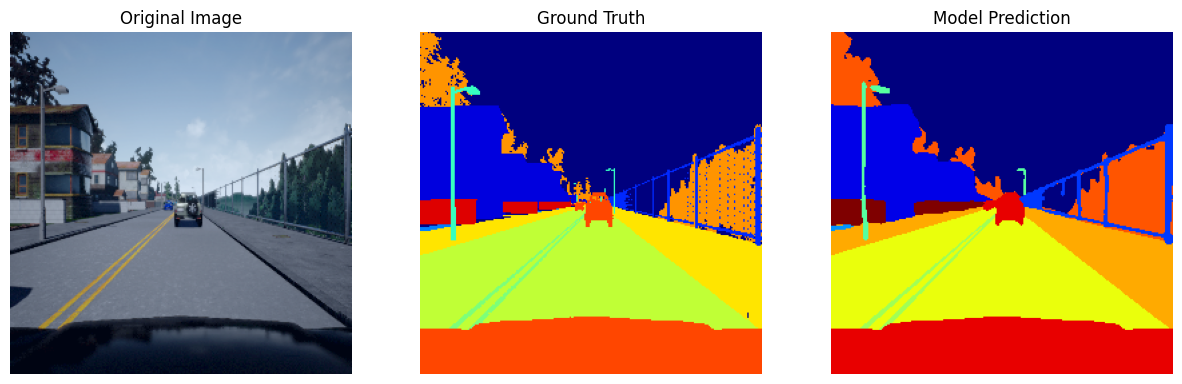

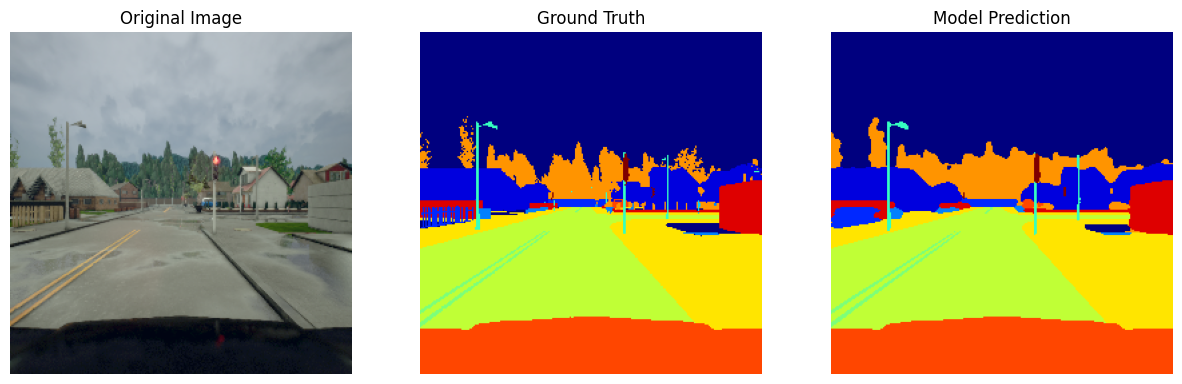

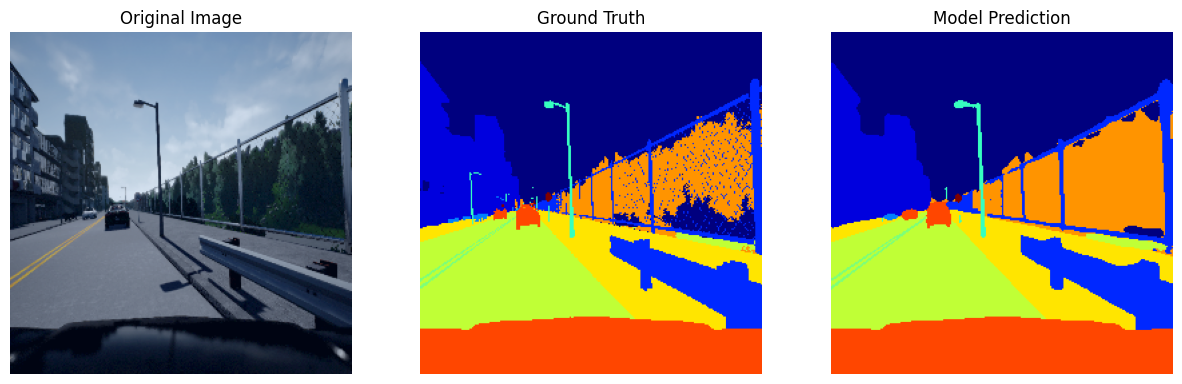

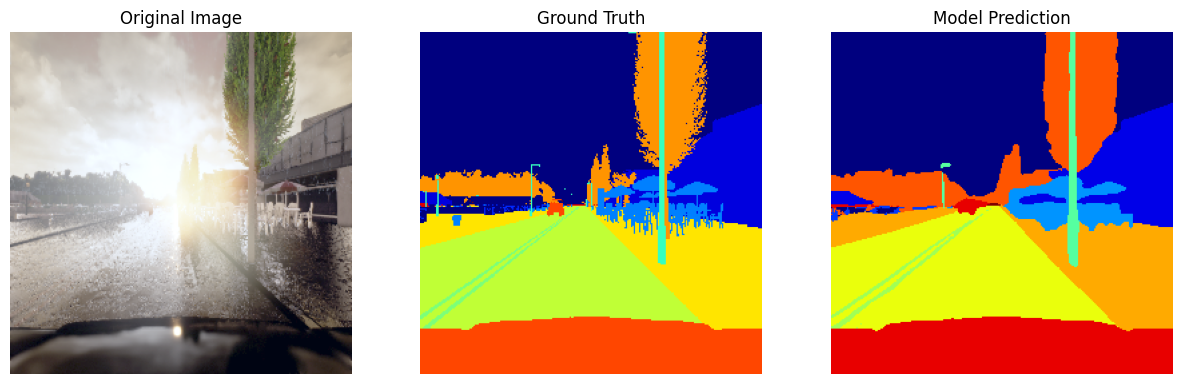

In [26]:
visualize_prediction(model, test_dataset, idx=10)
visualize_prediction(model, test_dataset, idx=50)
visualize_prediction(model, test_dataset, idx=40)
visualize_prediction(model, test_dataset, idx=20)